# Tutorial for the use of Pyal2 algorithm 

### 1. Introduction

This document aims in going through the pyal2 algorithm to calculate surface albedo parameters for a particular site and using VGT data. We would like to help new users to 'understand' which steps are performed before computing albedos.

The code entry is the wrapper.py program that can be launched like that for instance:

```
python3 ../pyal2/wrapper.py acf.c3s.vgt.yaml  pcf.c3s.vgt.yaml -s c3s --keywords name test-avignon sensorstringinfilenames vgt sensor vgt site Avignon --outputdates 2014-01-01,2017-02-01
```

In this case the sensor choosen is vgt and the site is Avignon. 

### 2. Initialisation

#### importing python libraries
This step is always the start of a python program

In [1]:
# First things:
pathPyal2 = '/home/pardem/albedo_dev/'

In [2]:
# librairies importation
from datetime import datetime
from datetime import timedelta
import argparse
import os
import sys
import time
import numpy as np
import yaml

try:
    import coloredlogs, logging
except ImportError:
    import logging

sys.path.append(pathPyal2 + '/pyal2_merge_angle_probav')

# Local libraries
import pyal2
from pyal2.readers.c3s.brdf import BrdfReader
from pyal2.exit_status import exit_status
from pyal2.chunking import chunk_2D, chunk_1D
from pyal2.parallel import ExceptionInSubprocessWrapper, chunk_init
from multiprocessing import Pool, Lock
from pyal2.data_store import DataStore


#### Initialisation of the DataStore
**We are here in the wrapper.py main() program**

A data_store is a dictionnary that store all the needed parameters: parameters stored in acf and pcf files, but also all filenames that will be used in the following steps, dates...
The data_store will launch different databox that contains parameters concerning each brdf/albedo calculation.

In [3]:
dstore = DataStore()

### 3. ******First Day******

#### 3.0. Loading configuration defined in acf and pcf files

**We are here in the wrapper.py main() program**

This part stores all general parameters and link, path in the data_store object.
Two parameters files are used, acf file (algorithm configuration file) and pcf file (product configuration file)

In [4]:
acffile = './acf.c3s.vgt.brdf.yaml'
pcffile = './pcf.c3s.vgt.brdf.yaml'
startseries = None # 
outputdates = [['2012-02-05','2012-03-08']]# Definition of the period we would like to have albedos
window_predefined = None
window_lat = None # Definition of a window we want to work in
window_lon = None
# Dictionnary of keywords that will fill gaps in parameter files
keywords = {'name': 'test-multi01', 'sensorstringinfilenames':'VGT', 'sensor':'VGT', 'site':'Avignon'}
config_format = 'yaml'

dstore.load_config(acffile, pcffile, startseries=startseries, dates=outputdates, 
                   debuglevel=3,
                   window_predefined=window_predefined,
                   window_lat=window_lat, 
                   window_lon=window_lon, 
                   keywords=keywords, 
                   config_format=config_format,
                   instruments=['VGT'])

CACHE ['toc_reflectance', 'band1']: fe6fd3a6a5252cf00f19b092d6a7f74cb : frozenset({('input_enddate_key', 'time_coverage_end'), ('dataloc_reader_name', 'dataloc_c3s_vgt'), ('filenames', './data_c3s/vgt/jupyter-avignon/c3s_L2B_*_Avignon_[0-9]*[0-9]_[0-9]KM_VGT_V1.0.1.nc'), ('input_startdate_key', 'time_coverage_start')})


CACHE ['toc_reflectance', 'band2']: fe6fd3a6a5252cf00f19b092d6a7f74cb : frozenset({('input_enddate_key', 'time_coverage_end'), ('dataloc_reader_name', 'dataloc_c3s_vgt'), ('filenames', './data_c3s/vgt/jupyter-avignon/c3s_L2B_*_Avignon_[0-9]*[0-9]_[0-9]KM_VGT_V1.0.1.nc'), ('input_startdate_key', 'time_coverage_start')})
CACHE ['toc_reflectance', 'band3']: fe6fd3a6a5252cf00f19b092d6a7f74cb : frozenset({('input_enddate_key', 'time_coverage_end'), ('dataloc_reader_name', 'dataloc_c3s_vgt'), ('filenames', './data_c3s/vgt/jupyter-avignon/c3s_L2B_*_Avignon_[0-9]*[0-9]_[0-9]KM_VGT_V1.0.1.nc'), ('input_startdate_key', 'time_coverage_start')})
CACHE ['toc_reflectance', 'band4']: fe6fd3a6a5252cf00f19b092d6a7f74cb : frozenset({('input_enddate_key', 'time_coverage_end'), ('dataloc_reader_name', 'dataloc_c3s_vgt'), ('filenames', './data_c3s/vgt/jupyter-avignon/c3s_L2B_*_Avignon_[0-9]*[0-9]_[0-9]KM_VGT_V1.0.1.nc'), ('input_startdate_key', 'time_coverage_start')})
CACHE ['toc_reflectance_cov', 'band1'

##### This data_store will be recorded in a file to be used in following steps (and following runs for further dates)

In [5]:
logdir = dstore.get('globalconfig', {}).get('logdir','.')
dstore.to_yaml(f'{logdir}/dstore.yaml')

".xoutputsize: 'Comment: xoutputsize should be the size                 of the output\n  file, xfullslice should be the size of the input file. Currently, they are identical.'\n.xoutputsize.: When processing only 1/10 pixels or 1/100 pixels,                     they\n  could be different, but this has not be implemented.\nVGT:\n  inputcheckpoint: {filename: output-test-multi01/Avignon/%Y/%m/c_c3s_brdf_%Y%m%d%H%M%S_Avignon_VGT_V1.0.nc,\n    firstdate: 2013/10/10, reader: c3s_brdf}\n  output:\n    albedo: {filename: output-test-multi01/Avignon/%Y/%m/c_c3s_al_%Y%m%d%H%M%S_Avignon_VGT_V1.0.nc}\n    brdf: {filename: output-test-multi01/Avignon/%Y/%m/c_c3s_brdf_%Y%m%d%H%M%S_Avignon_VGT_V1.0.nc}\n    date_pattern: 10_20_lastdayofthemonth\n    writer: c3s_writer\n  output_dates: [!!timestamp '2012-02-10 00:00:00', !!timestamp '2012-02-20 00:00:00',\n    !!timestamp '2012-02-29 00:00:00']\n  startseries: true\nacf:\n  nam_inv:\n    bad_cma_elim: false\n    bad_cma_factor: 10.0\n    brdf_clim_ac

#### 3.1. run the albedo calculation

##### 3.1.0 Data_Box initialisation
**We are here in the wrapper.py program**
 - The next function in pyal2 is process_one_chunk_no_parallele()
 - This function runs al2runner with dstore in parameter.
 
**We enter here in the al2runner.py process_one_date() program**

 - We will enter al2runner now going directly to the process_one_date() which will be run for each date
 - An important step is the creation of a data_box (dictionnary based object) that contains all the needed parameters, filenames, dates... that is needed to compute one BRDF. The 10 days of TOC filenames are mandatory to have sufficient data number to compute one BRDF.

In [9]:
from pyal2.al2_runner import Al2Runner
# Creation of a data_box from the data_store
previous_dbox = None
xslice = slice(0, 49, None)
yslice = slice(0, 49, None)
date = datetime(2012, 3, 10, 0, 0)

dbox = dstore.create_data_box(date, 'VGT', xslice, yslice, previous_date=None)

# Initialisation du al2runner:
runner = Al2Runner(dstore=dstore)
# creation of previous BRDF or reading previous BRDF
runner.get_checkpoint_data(dbox, date, 'VGT')

VGT
(['toc_reflectance', 'band1'], ['toc_reflectance', 'band2'], ['toc_reflectance', 'band3'], ['toc_reflectance', 'band4'], ['toc_reflectance_cov', 'band1'], ['toc_reflectance_cov', 'band2'], ['toc_reflectance_cov', 'band3'], ['toc_reflectance_cov', 'band4'], ['lwcs_mask'], ['azimuth_sol'], ['azimuth_sat', 'band1'], ['azimuth_sat', 'band1'], ['azimuth_sat', 'band1'], ['azimuth_sat', 'band1'], ['zenith_sol'], ['zenith_sat', 'band1'], ['zenith_sat', 'band1'], ['zenith_sat', 'band1'], ['zenith_sat', 'band1'], ['latitude'], ['longitude'])
Setting up empty initial brdf, often due to error


In [11]:
# loading input data
runner.get_input_data(dbox, 'VGT')
runner.currentdatetime = date
runner.day_of_year = date.timetuple().tm_yday

In [12]:
runner.initialize_output_and_intermediate_arrays(dbox)

##### 3.1.1  BRDF model fitting
**We are now ready to compute the first set of albedo parameters.**
 - First step for this computation is the BRDF calculation done by Fortran90 function model_fit (model_fit.f90)
 - model_fit is called by python in run_model_fit function where we will dive into this program now

In [16]:
def datetime_to_int64(d):
    """ This function transform a datetime object (or list of datetime objects) into a 64-bit integer to provide the number of seconds since a reference date.
        - using seconds allows to make sure that we do not have too many rounding issue (even if the input dates can have milliseconds
        - using 64 bits allows to process dates from 1900 to 2100 and more"""
    if isinstance(d, list):
        return np.array([datetime_to_int64(elt) for elt in d])
    if d < reference_date:
        logging.warn(f'date {d} is before the minimum supported date (which is {reference_date}. You may encounter some temporal paradox issues.')
    delta = d - reference_date
    delta_in_seconds = delta.total_seconds()
    delta_in_seconds = np.int64(delta_in_seconds)
    return delta_in_seconds
reference_date =  datetime(1900,1,1)
scenesdatetimes = datetime_to_int64(runner.scenesdatetimes)
currentdatetime = datetime_to_int64(runner.currentdatetime)
debuginfo = [0,1120,1,0,1120,1,0,0,1,0,0,1]
sensor = 'VGT'

if (dbox['acf']['spectral'][sensor]['nbands'] == 2) | (dbox['acf']['spectral'][sensor]['nbands'] == 3):
    index_red = 1
    index_nir = 2
elif dbox['acf']['spectral'][sensor]['nbands'] == 4:
    index_red=2
    index_nir=3
index2_red = 2
index2_nir = 3
# Running model_fit function

pyal2.lib.al2.model_fit(
               debuglevel = dbox['globalconfig']['debuglevel'],
               # input
               xstart=1, ystart=1,xend=runner.sizex, yend=runner.sizey,
               lwcs_mask= runner.lwcs_mask.values ,
               lwcs_mask_missing= runner.lwcs_mask.missing ,
               spectral_normalisation = dbox['acf']['spectral'][sensor]['spectral_normalisation'],
               spectral_normalisation_err = dbox['acf']['spectral'][sensor]['spectral_normalisation_err'],
               latitude= runner.latitude.values.astype('<f4') ,
               longitude= runner.longitude.values.astype('<f4'),
               model=                 dbox['model_id'],
               recursion=             dbox['acf']['nam_inv']['recursion']             ,
               startseries=           runner.current_startseries,
               composition=           dbox['acf']['nam_inv']['composition']           ,
               bad_cma_elim=          dbox['acf']['nam_inv']['bad_cma_elim']          ,
               bad_cma_factor=        dbox['acf']['nam_inv']['bad_cma_factor']        ,
               shadow_elim=           dbox['acf']['nam_inv']['shadow_elim']           ,
               shadow_factor=         dbox['acf']['nam_inv']['shadow_factor']         ,
               n_slot_elim=           dbox['acf']['nam_inv']['n_slot_elim']           ,
               n_obs_limit=           dbox['acf']['nam_inv']['n_obs_limit']           ,
               timescale=             dbox['acf']['nam_inv']['timescale']             ,
               snow_flag_one=         dbox['acf']['nam_inv']['snow_flag_one']         ,
               theta_sat_limit=       dbox['acf']['spectral'][sensor]['theta_sat_limit']       ,
               theta_sol_limit=       dbox['acf']['spectral'][sensor]['theta_sol_limit']       ,
               theta_sat_wlimit=      dbox['acf']['spectral'][sensor]['theta_sat_wlimit']      ,
               theta_sol_wlimit=      dbox['acf']['spectral'][sensor]['theta_sol_wlimit']      ,
               sig_nadir_a  =         np.array(dbox['acf']['nam_inv']['sig_nadir_a'], order='F', dtype='f4'),
               sig_nadir_b  =         np.array(dbox['acf']['nam_inv']['sig_nadir_b'], order='F', dtype='f4'),
               typical_cov_rescale_values = np.array(dbox['acf']['spectral'][sensor]['typical_cov_rescale'], order='F', dtype='f4'),
               sigrefl_min  =         dbox['acf']['nam_inv']['sigrefl_min'],
               sigrefl_max  =         dbox['acf']['nam_inv']['sigrefl_max'],
               k_reg  =               np.array(dbox['acf']['nam_inv']['k_reg'], order='F', dtype='f4'),
               sig_k_reg  =           np.array(dbox['acf']['nam_inv']['sig_k_reg'], order='F', dtype='f4'),
               par_max  = dbox['acf']['nam_scale']['par_max'],
               par_min  = dbox['acf']['nam_scale']['par_min'],
               cxx_max  = dbox['acf']['nam_scale']['cxx_max'],
               cxx_min  = dbox['acf']['nam_scale']['cxx_min'],
               cxy_max  = dbox['acf']['nam_scale']['cxy_max'],
               cxy_min  = dbox['acf']['nam_scale']['cxy_min'],
               day_of_year= runner.day_of_year ,
               days_last_in= runner.days_last_in ,
               zenith_sat= runner.zenith_sat.values,
               azimuth_sat= runner.azimuth_sat.values,
               zenith_sol= runner.zenith_sol.values,
               azimuth_sol= runner.azimuth_sol.values,
               reflectance= runner.reflectance.values,
               reflectance_cov= runner.reflectance_cov.values,
               scenesdatetimes= scenesdatetimes,
               currentdatetime= currentdatetime,
               quality_in= runner.quality_in.values     ,
               age_obs_in= runner.age_obs_in.values     ,
               brdf_in= runner.brdf_in.values           ,
               covariance_in= runner.covariance_in.values,
               brdf_clim = runner.brdf_clim.values      ,
               covariance_clim = runner.covariance_clim.values ,
               brdf_clim_activated = dbox['acf']['nam_inv']['brdf_clim_activated'],
               sat_specific = runner.sat_specific,
               enable_normalisation = dbox['acf']['spectral'][sensor]['enable_normalisation'],
               refl_outliers_elim_param1 = dbox['acf']['nam_inv'].get('refl_outliers_elim_param1',1.),
               refl_outliers_elim_param2 = dbox['acf']['nam_inv'].get('refl_outliers_elim_param2',3.),
               refl_outliers_elim_band_ref = dbox['acf']['nam_inv'].get('refl_outliers_elim_band_ref',-1), # for AVHRR this should be 2, for VGT it should be 1
               refl_outliers_elim_band_in = dbox['acf']['nam_inv'].get('refl_outliers_elim_band_in',-1), # this one it should be always 1
               ndvi_nir=index_nir, ndvi_red=index_red,
               ndvi2_nir=index2_nir, ndvi2_red=index2_red,
               # output
               brdf= runner.brdf.values ,
               brdf1= runner.brdf1.values ,
               quality = runner.quality.values,
               quality1 = runner.quality1.values,
               age_out = runner.age.values,
               n_valid_obs_out = runner.n_valid_obs_out.values,
               covariance= runner.covariance.values ,
               covariance1= runner.covariance1.values ,
               snow_mask_out= runner.snow_mask_out.values,
               debuginfo = debuginfo)

(0,
 b'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

##### 3.1.2 Angular integration
**BRDF are estimated, we will now compute angular integration using Fortran90 function called run_angular_integration()**

In [17]:
# Running albedo_angular_integration function 
pyal2.lib.al2.albedo_angular_integration(
               # input
               debuglevel = dbox['globalconfig']['debuglevel'],
               xstart=1, ystart=1,xend=runner.sizex, yend=runner.sizey,
               square_my_input_variance=True,
               k_array  = runner.brdf.values,
               ck_array = runner.covariance.values,
               latitude = runner.latitude.values.astype('<f4') ,
               longitude= runner.longitude.values.astype('<f4'),
               theta_ref_dh_limit   = dbox['acf']['spectral'][sensor]['theta_ref_dh_limit'],
               theta_sol_midi_limit = dbox['acf']['spectral'][sensor]['theta_sol_midi_limit'],
               day_of_year = runner.day_of_year,
               snow_mask_out= runner.snow_mask_out.values,
               model    = dbox['acf']['nam_inv']['model'],
               alb_max  = dbox['acf']['nam_scale']['alb_max'],
               alb_min  = dbox['acf']['nam_scale']['alb_min'],
               sig_max  = dbox['acf']['nam_scale']['sig_max'],
               sig_min  = dbox['acf']['nam_scale']['sig_min'],
               cxx_max  = dbox['acf']['nam_scale']['cxx_max'],
               cxy_max  = dbox['acf']['nam_scale']['cxy_max'],
               cxy_min  = dbox['acf']['nam_scale']['cxy_min'],
               # output
               albedos = runner.albedos.values,
               albedos_cov = runner.albedos_cov.values,
               age = runner.age.values, albedos_age = runner.albedos_age.values,
               quality = runner.quality.values, albedos_quality = runner.albedos_quality.values,
               debuginfo = debuginfo)

# Changing albedo covariance values due to spectral normalisation
for iband in range(0, runner.albedos_cov.values.shape[2]):
            a = dbox['acf']['spectral'][sensor]['spectral_normalisation_err'][0,iband,2]
            b = dbox['acf']['spectral'][sensor]['spectral_normalisation_err'][0,iband,3]
            runner.albedos_cov.values[:,:,iband,:] = a + b * runner.albedos_cov.values[:,:,iband,:]


##### 3.1.3 Spectral integration
**Once the angular integrations are done, the next step is the spectral integration done py the Fortran90 function called run_spectral_integration()**

In [18]:
pyal2.lib.al2.albedo_spectral_integration(
               debuglevel = dbox['globalconfig']['debuglevel'],
               # input
               xstart=1, ystart=1,xend=runner.sizex, yend=runner.sizey,
               albedos = runner.albedos.values,
               albedos_cov = runner.albedos_cov.values ,
               albedos_age = runner.albedos_age.values ,
               albedos_quality = runner.albedos_quality.values,
               mask_array = runner.snow_mask_out.values,
               latitude= runner.latitude.values.astype('<f4') ,
               longitude= runner.longitude.values.astype('<f4'),
               coeffs = dbox['coeffs'],
               sigma_co  = dbox['acf']['nam_inv']['sigma_co'],
               alb_max  = dbox['acf']['nam_scale']['alb_max'],
               alb_min  = dbox['acf']['nam_scale']['alb_min'],
               sig_max  = dbox['acf']['nam_scale']['sig_max'],
               sig_min  = dbox['acf']['nam_scale']['sig_min'],
               # output
               outalbedos = runner.outalbedos.values,
               outalbedos_cov = runner.outalbedos_cov.values ,
               outalbedos_age = runner.outalbedos_age.values ,
               outalbedos_quality = runner.outalbedos_quality.values,
               debuginfo = debuginfo)


(0,
 b'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

#### 3.2. Writing outputs 

In [20]:
from pyal2.writers import get_data_writer

# To write the data, we use the object writer defined in pyal2/writer/c3s
data_writer_class, _ = get_data_writer(dbox[sensor]['output']['writer'])
# create a writer object with all the relevant parameters
writer = data_writer_class(config=dbox[sensor]['output'],
                            xoutputsize=dbox['xoutputsize'],
                            youtputsize=dbox['youtputsize'],
                            n_channels_ref=dbox['n_channels_ref'],
                            model_len=dbox['model_len'],
                            model_id=dbox['model_id'],
                            output_channel_names=dbox['acf']['output_channel_names'],
                            outalbedos_names=dbox['outalbedos_names'],
                            inalbedos_names=dbox['inalbedos_names'],
                            xslice=xslice, yslice=yslice, date=date)

writer.write_all_brdf(runner)
writer.write_all_spectral_albedos(runner)
writer.write_all_albedos(runner)

- We now have to files in the following folder output/Avignon/2012/02/
- one file is the albedo : c_c3s_al_20120210000000_Avignon_VGT_V1.0.nc
- the other is the brdf : c_c3s_brdf_20120210000000_Avignon_VGT_V1.0.nc

#### 3.3 Visualization of some of the outputs

First we will plot some BRDF k values

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

chanVGT=['B0','B2','B3','MIR']

brdf = runner.brdf.values
cms = cm.get_cmap('jet')

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=4,  figsize=(30,20))
for i in [0, 1, 2, 3]:
    im1=ax1[i].imshow(brdf[:,:,i,0], cmap=cms)
    im2=ax2[i].imshow(brdf[:,:,i,1], cmap=cms)
    im3=ax3[i].imshow(brdf[:,:,i,2], cmap=cms)
    ax1[i].set_title(f'Channel {chanVGT[i]}',fontsize=30)

    
    cb1=plt.colorbar(im1, ax=ax1[i], orientation='horizontal', shrink=0.7);
    cb1.set_label(f"BRDF channel {chanVGT[i]}", labelpad=-1, size=20)
    cb1.ax.tick_params(labelsize=25) 

    cb2=plt.colorbar(im2, ax=ax2[i], orientation='horizontal', shrink=0.7);
    cb2.set_label(f"BRDF channel {chanVGT[i]}", labelpad=-1, size=20)
    cb2.ax.tick_params(labelsize=25) 
    
    cb3=plt.colorbar(im3, ax=ax3[i], orientation='horizontal', shrink=0.7);
    cb3.set_label(f"BRDF channel {chanVGT[i]}", labelpad=-1, size=20)
    cb3.ax.tick_params(labelsize=25) 

ax1[0].set_ylabel('K0 parameter', fontsize=30)
ax2[0].set_ylabel('K1 parameter', fontsize=30)
ax3[0].set_ylabel('K2 parameter', fontsize=30)

plt.show()

<Figure size 3000x2000 with 24 Axes>

We may now want to see what Spectral albedos look like:

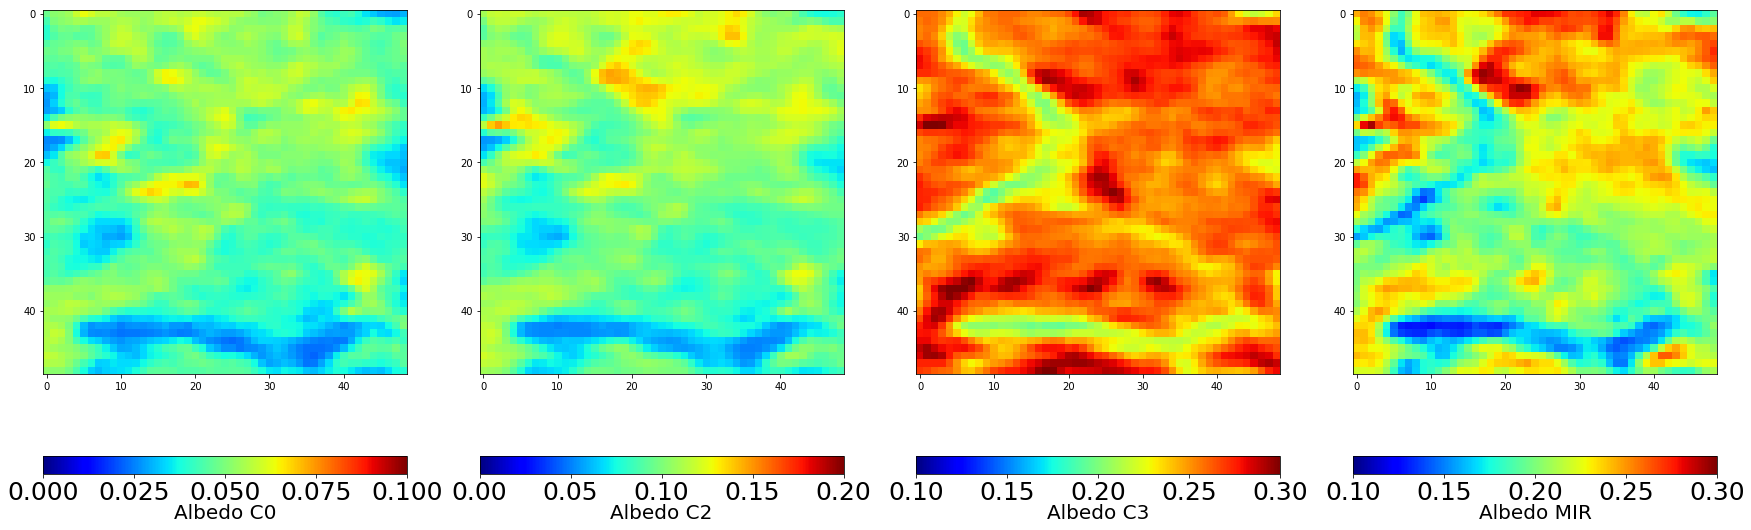

In [28]:
albedos = runner.albedos.values

fig, (ax1, ax2, ax3, ax4)=plt.subplots(ncols=4,  figsize=(30,10))

# C0
im1 = ax1.imshow(albedos[:,:,0,0], cmap=cms, vmin=0.0, vmax=0.1);
cb1 = plt.colorbar(im1, ax=ax1,orientation='horizontal');
cb1.set_label("Albedo C0", labelpad=-1, size=20)
cb1.ax.tick_params(labelsize=25)

im2=ax2.imshow(albedos[:,:,1,0], cmap=cms, vmin=0., vmax=0.2);
cb2=plt.colorbar(im2, ax=ax2, orientation='horizontal');
cb2.set_label("Albedo C2", labelpad=-1, size=20)
cb2.ax.tick_params(labelsize=25)

im3=ax3.imshow(albedos[:,:,2,0], cmap=cms, vmin=0.1, vmax=0.3);
cb3=plt.colorbar(im3, ax=ax3, orientation='horizontal');
cb3.set_label("Albedo C3", labelpad=-1, size=20)
cb3.ax.tick_params(labelsize=25)

im4=ax4.imshow(albedos[:,:,3,0], cmap=cms, vmin=0.1, vmax=0.3);
cb4=plt.colorbar(im3, ax=ax4, orientation='horizontal');
cb4.set_label("Albedo MIR", labelpad=-1, size=20)
cb4.ax.tick_params(labelsize=25)

At the end we would like to have a look to the Broadband Albedos

(49, 49, 2, 3)


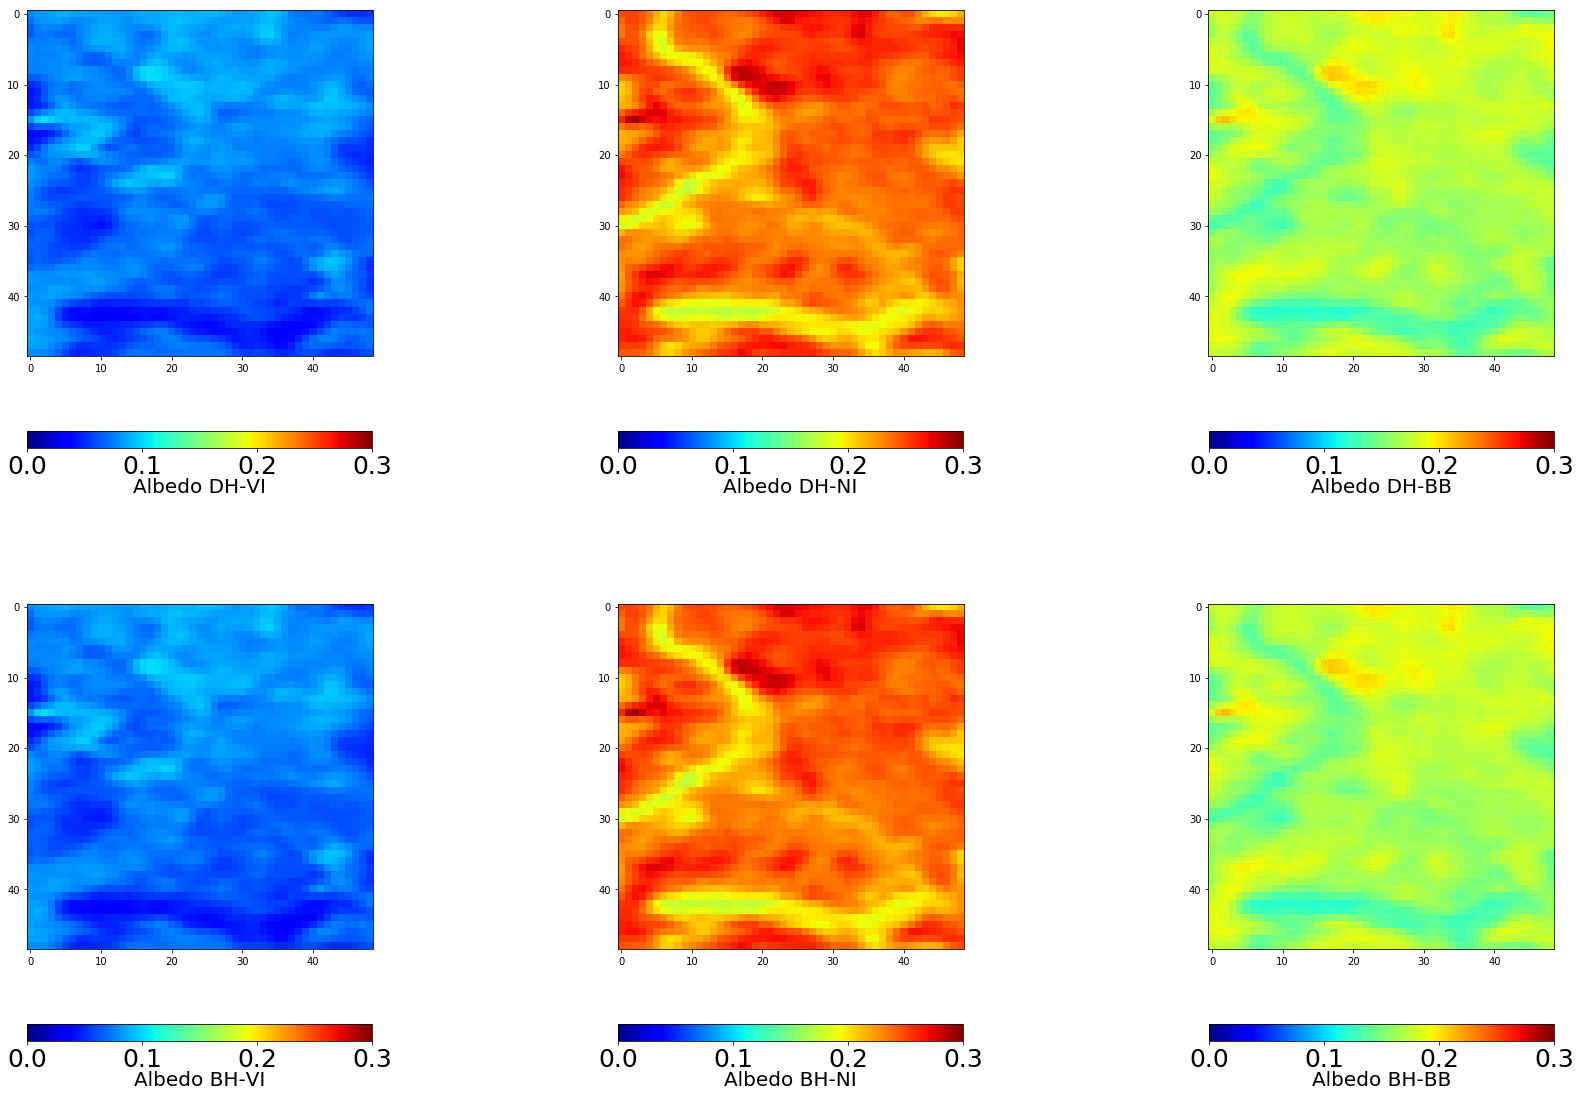

In [50]:
outalbedos = runner.outalbedos.values

fig, (ax1, ax2)=plt.subplots( nrows=2, ncols=3, figsize=(30,20))

# C0
im1 = ax1[0].imshow(outalbedos[:,:,0,0], cmap=cms, vmin=0.0, vmax=0.3);
cb1 = plt.colorbar(im1, ax=ax1[0],orientation='horizontal', shrink=0.7);
cb1.set_label("Albedo DH-VI", labelpad=-1, size=20)
cb1.ax.tick_params(labelsize=25)

im2=ax1[1].imshow(outalbedos[:,:,0,1], cmap=cms, vmin=0., vmax=0.3);
cb2=plt.colorbar(im2, ax=ax1[1], orientation='horizontal', shrink=0.7);
cb2.set_label("Albedo DH-NI", labelpad=-1, size=20)
cb2.ax.tick_params(labelsize=25)

im3=ax1[2].imshow(outalbedos[:,:,0,2], cmap=cms, vmin=0., vmax=0.3);
cb3=plt.colorbar(im3, ax=ax1[2], orientation='horizontal', shrink=0.7);
cb3.set_label("Albedo DH-BB", labelpad=-1, size=20)
cb3.ax.tick_params(labelsize=25)

# C0
im1 = ax2[0].imshow(outalbedos[:,:,1,0], cmap=cms, vmin=0.0, vmax=0.3);
cb1 = plt.colorbar(im1, ax=ax2[0],orientation='horizontal', shrink=0.7);
cb1.set_label("Albedo BH-VI", labelpad=-1, size=20)
cb1.ax.tick_params(labelsize=25)

im2=ax2[1].imshow(outalbedos[:,:,1,1], cmap=cms, vmin=0., vmax=0.3);
cb2=plt.colorbar(im2, ax=ax2[1], orientation='horizontal', shrink=0.7);
cb2.set_label("Albedo BH-NI", labelpad=-1, size=20)
cb2.ax.tick_params(labelsize=25)

im3=ax2[2].imshow(outalbedos[:,:,1,2], cmap=cms, vmin=0., vmax=0.3);
cb3=plt.colorbar(im3, ax=ax2[2], orientation='horizontal', shrink=0.7);
cb3.set_label("Albedo BH-BB", labelpad=-1, size=20)
cb3.ax.tick_params(labelsize=25)

### 4. ** Second Day **

- **Again we will create a new data_box, with the following date, corresponding to 10 days after the first computation**

In [15]:
date = datetime(2012, 2, 20, 0, 0)
dbox = dstore.create_data_box(date, xslice, yslice, previous_date=datetime(2012, 2, 10, 0, 0))

# Initialisation du al2runner:
runner = Al2Runner(dstore=dstore)
# creation of previous BRDF or reading previous BRDF
runner.get_checkpoint_data(dbox, date)

In [16]:
# On vérifie les dates concernées et que la brdf précédente est effectivement lue:
print(dbox.keys())
print(dbox['previous_date'] )

dict_keys(['date', 'xslice', 'yslice', 'acf_file', 'pcf_file', 'globalconfig', 'n_channels_ref', 'output_dates', 'inputcheckpoint', 'output', 'startseries', 'input', 'xoutputsize', 'youtputsize', 'xfullsize', 'yfullsize', 'xfullslice', 'yfullslice', '.xoutputsize', '.xoutputsize.', 'sensorname', 'n_channels_meas', 'acf', 'time_span_for_composition', 'model_len', 'model_id', 'n_mask', 'inalbedos_names', 'outalbedos_names', 'nalbedos', 'n_outalbedos', 'coeffs', 'previous_date'])
2012-02-10 00:00:00


- **We have to load new data files** 

In [17]:
# loading input data
runner.get_input_data(dbox)
runner.currentdatetime = date
runner.day_of_year = date.timetuple().tm_yday

- **Now we will launch all three fortran functions : model_fit, angular integration and spectral integration**

In [18]:
runner.initialize_output_and_intermediate_arrays(dbox)

runner.run_model_fit(dbox)
runner.run_angular_integration(dbox)
runner.run_spectral_integration(dbox)

- **We are now at the end of the second day process. We will write brdf and albedos**

In [19]:
# To write the data, we use the object writer defined in pyal2/writer/c3s
data_writer_class, _ = get_data_writer(dbox['output']['writer'])
# create a writer object with all the relevant parameters
writer = data_writer_class(config=dbox['output'],
                            xoutputsize=dbox['xoutputsize'],
                            youtputsize=dbox['youtputsize'],
                            n_channels_ref=dbox['n_channels_ref'],
                            model_len=dbox['model_len'],
                            model_id=dbox['model_id'],
                            output_channel_names=dbox['acf']['output_channel_names'],
                            outalbedos_names=dbox['outalbedos_names'],
                            inalbedos_names=dbox['inalbedos_names'],
                            xslice=xslice, yslice=yslice, date=date)

writer.write_all_brdf(runner)
writer.write_all_spectral_albedos(runner)
writer.write_all_albedos(runner)

### 5. **Visualisation of the outputdata**

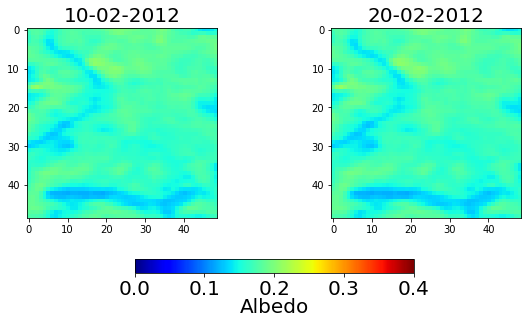

In [51]:
import xarray as xr
import sys, glob
#sys.path.insert(0, "/home/pardem/albedo_dev/pyal2/")
#import pyal2.validation.gather as gather  
#import importlib;importlib.reload(gather);
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib

#%matplotlib notebook

file10 = f'output/Avignon/2012/02/c_c3s_al_20120210000000_Avignon_VGT_V1.0.nc'
file20 = f'output/Avignon/2012/02/c_c3s_al_20120220000000_Avignon_VGT_V1.0.nc'
arr10 = xr.open_mfdataset(file10)
arr20 = xr.open_mfdataset(file20)

cm = matplotlib.cm.get_cmap('jet')

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('10-02-2012', size=20)
ax[1].set_title('20-02-2012', size=20)
im = ax[0].imshow(arr10['AL-BH-BB'].values, vmin=0, vmax=0.4, cmap=cm)
im = ax[1].imshow(arr20['AL-BH-BB'].values, vmin=0, vmax=0.4, cmap=cm)
cb=plt.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5)
cb.set_label("Albedo", labelpad=-1, size=20)
cb.ax.tick_params(labelsize=20)

plt.show()